In [76]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
from umap.umap_ import UMAP
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [3]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v3_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

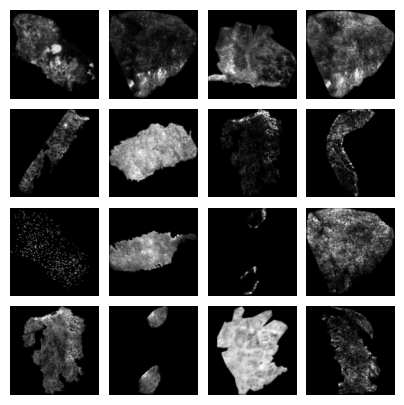

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [5]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [7]:
# Hyperparameters
latent_dim = 20
epochs = 10
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cuda")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/10, Loss: 97643.8251, Time: 2.87 sec
Epoch 2/10, Loss: 67865.5878, Time: 1.51 sec
Epoch 3/10, Loss: 66874.9191, Time: 1.65 sec
Epoch 4/10, Loss: 65352.6004, Time: 1.62 sec
Epoch 5/10, Loss: 63688.1125, Time: 1.53 sec
Epoch 6/10, Loss: 62110.3033, Time: 1.63 sec
Epoch 7/10, Loss: 60900.0304, Time: 1.65 sec
Epoch 8/10, Loss: 60038.1929, Time: 1.84 sec
Epoch 9/10, Loss: 59271.8705, Time: 1.89 sec
Epoch 10/10, Loss: 58722.5011, Time: 1.96 sec


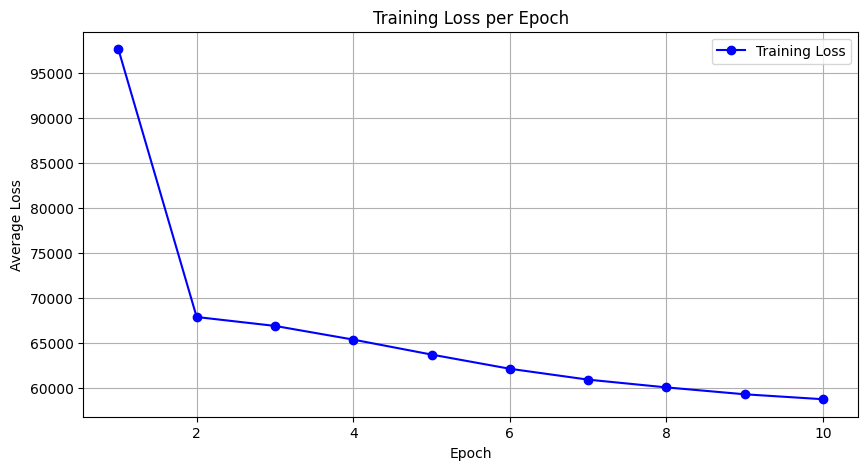

In [8]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

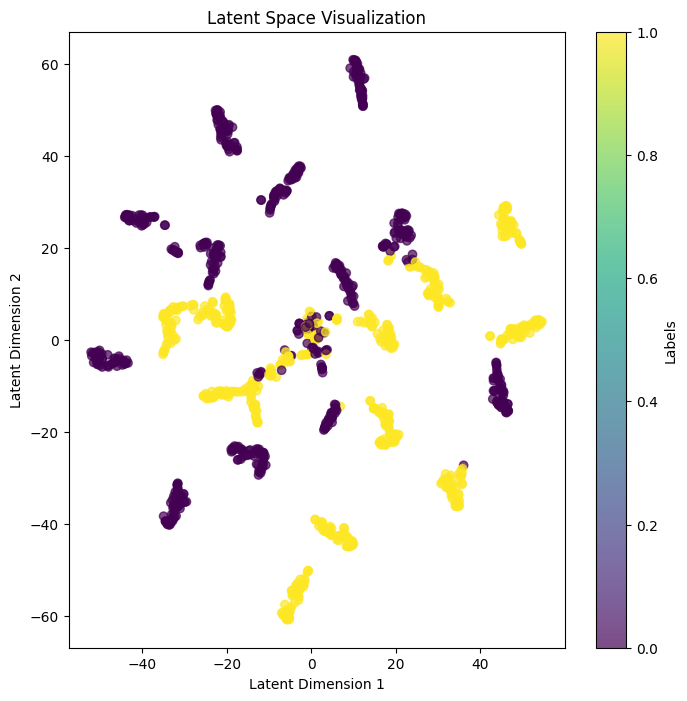

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, method='tsne'):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if method == 'tsne':
            latents_2d = TSNE(perplexity=20, n_components=2).fit_transform(latents)
        elif method == 'pca':
            latents_2d = PCA(n_components=2).fit_transform(latents)
        elif method == 'umap':
            latents_2d = UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, dataloader, latent_dim=10, method='tsne')


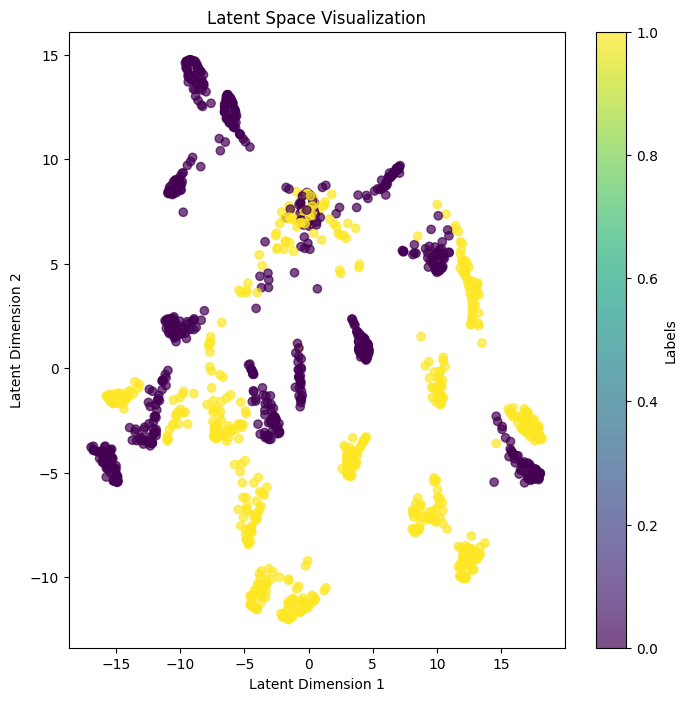

In [ ]:
visualize_latent_space(model, dataloader, latent_dim=10, method='pca')

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


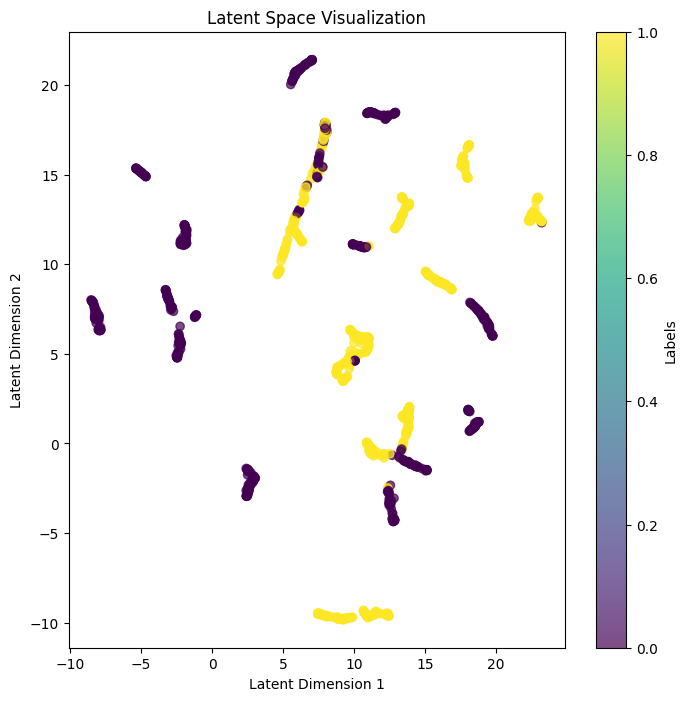

In [11]:
visualize_latent_space(model, dataloader, latent_dim=10, method='umap')

In [20]:
import torch.nn as nn
def extract_latent_features(model, dataloader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use mu as the latent representation
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents)
    labels = torch.cat(labels)
    return latents, labels

latent_vectors, target_labels = extract_latent_features(model, dataloader)


In [21]:
latent_features_np = latent_vectors.cpu().numpy()  # Move to CPU and convert to NumPy
target_labels_np = target_labels.cpu().numpy()
np.save("latent_features.npy", latent_features_np)
np.save("target_labels.npy", target_labels_np)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

latent_features = np.load("latent_features.npy")
labels = np.load("target_labels.npy") 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.25, random_state=42)

# Train a classifier on the latent features
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 96.47%


In [23]:
import os
from PIL import Image
import torch
import zarr
import numpy as np
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
                 'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
                 'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N',
             'SQ1634_s1_N', 'SQ1634_s2_R', 'SQ1634_s3_R', 'SQ1634_s4_N',
             'SQ1635_s1_N', 'SQ1635_s2_R', 'SQ1635_s3_R', 'SQ1635_s4_N',
             'SQ1636_s1_R', 'SQ1636_s2_N', 'SQ1636_s3_N', 'SQ1636_s4_R']

tile_ls = []
label_ls = []

folder_path = '/home/mass_spec_img/mass_spec_img/data/zarr'
for sample in sample_ls:
    zarr_path = f'{folder_path}/{sample}/slide.zarr'
    slide = zarr.open(zarr_path, mode='r')
    print(f'Zarr dataset loaded from {zarr_path}')
    tile_ls.append(slide)
    if sample.startswith("SQ1631"):
        if "s1" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1632"):
        if "s4" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1633"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(2)
    elif sample.startswith("SQ1634"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1635"):
        if "s3" in sample or "s4" in sample:
            label_ls.append(2)
        elif "s1" in sample:
            label_ls.append(1)
        else:
            label_ls.append(0)
    else:
        if "s4" in sample:
            label_ls.append(1)
        else:
            label_ls.append(2)

Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1631_s1_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1631_s2_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1631_s3_N/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1631_s4_N/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1632_s1_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1632_s2_N/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1632_s3_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1632_s4_N/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1633_s1_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1633_s2_R/slide.zarr
Zarr dataset loaded from /home/mass_spec_img/mass_spec_img/data/zarr/SQ1633_s3_N

In [61]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (500 // 8) * (500 // 8), 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(torch.unique(labels)))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (500 // 8) * (500 // 8))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [37]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [39]:
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 3 # number of classes in the output
model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from tqdm.notebook import tqdm
import torch

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


In [64]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

In [65]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)

Epoch 1/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Accuracy: 0.9992


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0014, Test Accuracy: 0.9994
Epoch 2/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Accuracy: 0.9997


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0007, Test Accuracy: 0.9998
Epoch 3/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0012, Test Accuracy: 0.9995
Epoch 4/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0010, Test Accuracy: 0.9995
Epoch 5/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0002, Test Accuracy: 1.0000


In [66]:
# Dataset implementation for your specific case
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.sample_dict = defaultdict(list)
        self.labels = []
        self.samples = []


        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
            
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                self.sample_dict[img_path.split("/")[-1][:8]].append(img_array)
        # convert the dictionary into list so we can get the samples by indexing
        for sample in self.sample_dict:
            self.samples.append(self.sample_dict[sample])
            slide_num = sample[:6]
            tissue_num = sample[6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)


        

    def _load_image_as_tensor(self, path):
        """
        Load an image as a NumPy array.
        
        Args:
            path (str): Path to image file
            
        Returns:
            np.ndarray: Image as NumPy array with shape [H, W]
        """
        # Open image using PIL
        with Image.open(path) as img:
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # Convert to NumPy array
            img_np = np.array(img, dtype=np.float32)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            # transform the tensor if needed
            if self.transform:
                img_tensor = self.transorm(img_tensor)
        return img_tensor
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        
        # Stack list of images for each tissue to form a 50-channel tensor
        sample_tensor = torch.stack(sample, dim=0)  # Shape: [50, H, W]
        sample_tensor = sample_tensor.squeeze(1) # remove the color channel for each individual image, so the multidimensional
            
        return sample_tensor, label

In [42]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2):
        """
        Modified ResNet model to handle multi-channel inputs beyond RGB.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
        """
        super(MultiChannelResnet, self).__init__()
        
        # Load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # Initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # Scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # Only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # Initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # Replace the layer
        self.model.conv1 = new_layer
        
        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        return self.model(x)

In [67]:
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v3_greyscale/'
dataset = MultiChannelDataset(folder_path, transform=None)
# Calculate the sizes for the split
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 75% for training
test_size = total_size - train_size  # 25% for testing


In [69]:
# Create dataset and dataloadercal

train_dataset, test_dataset = random_split(
        dataset, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )
# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4
)

 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = MultiChannelResnet(num_channels=52, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    # Print epoch training statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate testing metrics
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    # Print testing statistics
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")
    print("-" * 60)

Epoch 1/20
Train Loss: 1.0610 | Train Acc: 47.37%
Test Loss: 9.0549 | Test Acc: 80.00%
------------------------------------------------------------
Epoch 2/20
Train Loss: 2.9889 | Train Acc: 63.16%
Test Loss: 53.5117 | Test Acc: 40.00%
------------------------------------------------------------
Epoch 3/20
Train Loss: 1.6892 | Train Acc: 73.68%
Test Loss: 1.7400 | Test Acc: 60.00%
------------------------------------------------------------
Epoch 4/20
Train Loss: 1.1811 | Train Acc: 73.68%
Test Loss: 14.2624 | Test Acc: 40.00%
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.4618 | Train Acc: 73.68%
Test Loss: 37.2330 | Test Acc: 40.00%
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.3773 | Train Acc: 84.21%
Test Loss: 17.6091 | Test Acc: 40.00%
------------------------------------------------------------
Epoch 7/20
Train Loss: 0.4955 | Train Acc: 73.68%
Test Loss: 13.5718 | Test Acc: 40.00%
--------------------

In [70]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v3_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=transform)


In [71]:
tissue_ids = ["SQ1631S1", "SQ1631S2", "SQ1631S3", "SQ1631S4",
              "SQ1632S1", "SQ1632S2", "SQ1632S3", "SQ1632S4",
              "SQ1633S1", "SQ1633S2", "SQ1633S3", "SQ1633S4",
              "SQ1634S1", "SQ1634S2", "SQ1634S3", "SQ1634S4",
              "SQ1635S1", "SQ1635S2", "SQ1635S3", "SQ1635S4",
              "SQ1636S1", "SQ1636S2", "SQ1636S3", "SQ1636S4"]
total_size = len(tissue_ids)
train_size = int(0.8 * len(tissue_ids))  # 80% for training
test_size = len(tissue_ids) - train_size  # 20% for testing
# Create dataset and dataloader
train_ids, test_ids = random_split(
        tissue_ids, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )
train_ids, test_ids = list(train_ids), list(test_ids)
train_idx = []
test_idx = []
for i, img_path in enumerate(dataset.image_files):
        tissue_id = img_path.split("/")[-1].split("_")[0]
        if tissue_id in train_ids:
                train_idx.append(i)
        else:
                test_idx.append(i)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)


    

In [73]:

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4
)

 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
"""optimizer = torch.optim.SGD(model.parameters(), 
                           lr=0.005, 
                           momentum=0.5, 
                           weight_decay=1e-5)"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    # Print epoch training statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate testing metrics
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    # Print testing statistics
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")
    print("-" * 60)

Epoch 1/20
Train Loss: 0.7568 | Train Acc: 58.70%
Test Loss: 3.5911 | Test Acc: 60.00%
------------------------------------------------------------
Epoch 2/20
Train Loss: 0.3356 | Train Acc: 85.93%
Test Loss: 0.3821 | Test Acc: 79.23%
------------------------------------------------------------
Epoch 3/20
Train Loss: 0.2152 | Train Acc: 91.70%
Test Loss: 0.6164 | Test Acc: 69.23%
------------------------------------------------------------
Epoch 4/20
Train Loss: 0.1363 | Train Acc: 95.04%
Test Loss: 0.4770 | Test Acc: 71.54%
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.0819 | Train Acc: 96.76%
Test Loss: 1.2762 | Test Acc: 69.23%
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.0800 | Train Acc: 97.27%
Test Loss: 0.4289 | Test Acc: 71.54%
------------------------------------------------------------
Epoch 7/20
Train Loss: 0.0324 | Train Acc: 98.28%
Test Loss: 0.5961 | Test Acc: 71.54%
-------------------------

In [105]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_classes, cutmix_prob=0.5, alpha=1.0):
        self.dataset = original_dataset
        self.cutmix = v2.CutMix(num_classes=num_classes, alpha=alpha)
        self.cutmix_prob = cutmix_prob
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Decide whether to use CutMix based on probability
        use_cutmix = torch.rand(1).item() < self.cutmix_prob
        
        if not use_cutmix:
            img, label = self.dataset[index]
            img = self.transform(img)
            # Create one-hot distribution for original image (1.0 for true class, 0 elsewhere)
            label_dist = torch.zeros(self.num_classes, dtype=torch.float32)
            label_dist[label] = 1.0
            return img, label_dist
        
        # Apply CutMix
        img1, label1 = self.dataset[index]
        idx2 = torch.randint(len(self.dataset), (1,)).item()
        img2, label2 = self.dataset[idx2]
        
        img1, img2 = self.transform(img1), self.transform(img2)
        batch = torch.stack([img1, img2])
        labels = torch.tensor([label1, label2], dtype=torch.long)
        
        mixed_batch, mixed_labels = self.cutmix(batch, labels)
        return mixed_batch[0], mixed_labels[0]

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v3_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=transform)

tissue_ids = ["SQ1631S1", "SQ1631S2", "SQ1631S3", "SQ1631S4",
              "SQ1632S1", "SQ1632S2", "SQ1632S3", "SQ1632S4",
              "SQ1633S1", "SQ1633S2", "SQ1633S3", "SQ1633S4",
              "SQ1634S1", "SQ1634S2", "SQ1634S3", "SQ1634S4",
              "SQ1635S1", "SQ1635S2", "SQ1635S3", "SQ1635S4",
              "SQ1636S1", "SQ1636S2", "SQ1636S3", "SQ1636S4"]
total_size = len(tissue_ids)
train_size = int(0.8 * len(tissue_ids))  # 80% for training
test_size = len(tissue_ids) - train_size  # 20% for testing
# Create dataset and dataloader
train_ids, test_ids = random_split(
        tissue_ids, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )
train_ids, test_ids = list(train_ids), list(test_ids)
train_idx = []
test_idx = []
for i, img_path in enumerate(dataset.image_files):
        tissue_id = img_path.split("/")[-1].split("_")[0]
        if tissue_id in train_ids:
                train_idx.append(i)
        else:
                test_idx.append(i)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

augmented_train_dataset = AugmentedDataset(train_dataset, num_classes=2)
augmented_train_loader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

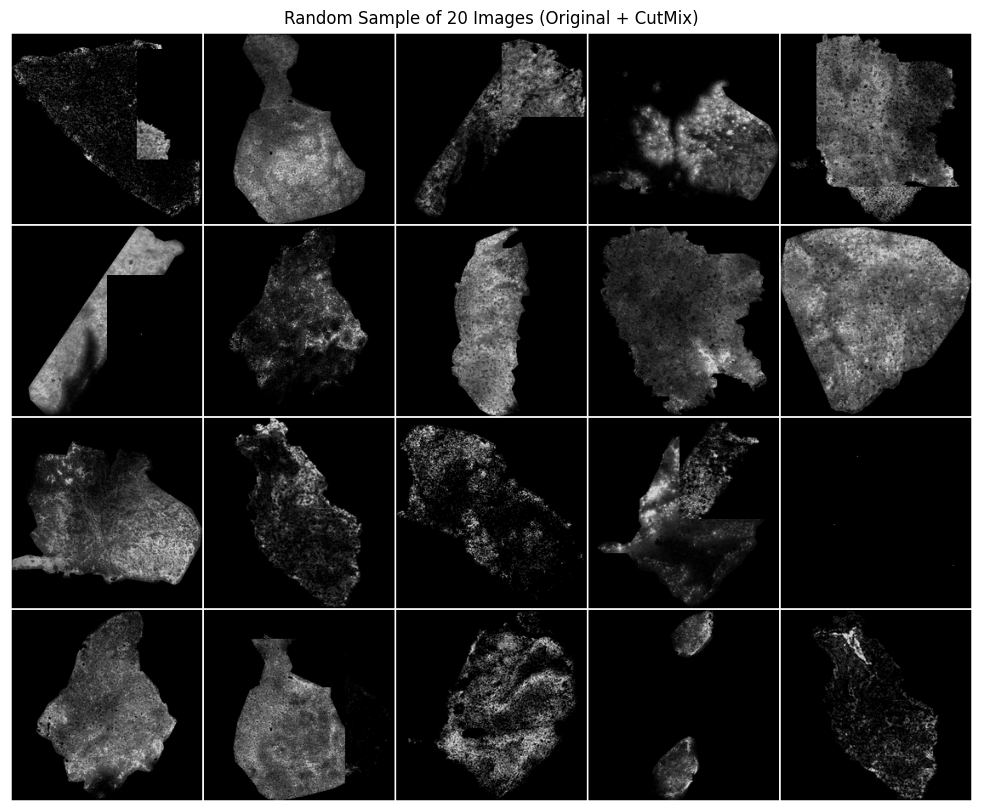

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Get 20 random indices
random_indices = np.random.randint(0, len(augmented_train_dataset), 20)

# Create figure
plt.figure(figsize=(20, 10))

# Get and display images
images = []
for idx in random_indices:
    img, label = augmented_train_dataset[idx]
    if isinstance(label, torch.Tensor) and len(label.shape) > 0:
        # For CutMix images, show the mix ratio in title
        label_str = f"Mix: {label.numpy().round(2)}"
    else:
        # For original images, show the class label
        label_str = f"Class: {label}"
        
    images.append(img)
    
# Create grid of images
grid = make_grid(images, nrow=5, normalize=True, pad_value=1.0)

# Display grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Random Sample of 20 Images (Original + CutMix)')
plt.show()

# Print labels
for i, idx in enumerate(random_indices):
    _, label = augmented_train_dataset[idx]

In [123]:
from transformers import ConvNextForImageClassification

num_epochs = 10
learning_rate = 0.01
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SoftCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        log_softmax = F.log_softmax(input, dim=1)
        return torch.mean(torch.sum(-target * log_softmax, dim=1))

# initialize optimizer, scheduler, and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = SoftCrossEntropyLoss()


model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
model.classifier = torch.nn.Linear(model.config.hidden_sizes[-1], num_classes)

model = model.to(device)


best_acc = 0.0
best_model = None

print(f"Training on {device}")
print("=" * 50)

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, target_distributions in augmented_train_loader:
        inputs = inputs.to(device)
        target_distributions = target_distributions.to(device)

        outputs = model(inputs)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        loss = criterion(logits, target_distributions)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = logits.max(1)
        total += target_distributions.size(0)
        true_classes = target_distributions.max(1)[1]
        correct += predicted.eq(true_classes).sum().item()
    
    train_loss = running_loss / len(augmented_train_loader)
    train_acc = 100. * correct / total
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, targets)
            
            test_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    scheduler.step()
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model.state_dict().copy()
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.2f}s)")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print("-" * 50)

torch.save(best_model, 'best_model.pth')
print(f"Training completed. Best test accuracy: {best_acc:.2f}%")

Training on cuda
Epoch [1/10] (358.79s)
Train Loss: 0.6978 | Train Acc: 48.99%
Test Loss: 0.8333 | Test Acc: 52.31%
Learning Rate: 0.010000
--------------------------------------------------
Epoch [2/10] (361.07s)
Train Loss: 0.6973 | Train Acc: 47.37%
Test Loss: 0.8336 | Test Acc: 52.31%
Learning Rate: 0.010000
--------------------------------------------------


KeyboardInterrupt: 

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # For UMAP visualization if needed
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

# Define the Sparse Autoencoder network
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=224*224, hidden_size=128, latent_size=64, sparsity_param=0.05):
        super(SparseAutoencoder, self).__init__()
        
        self.sparsity_param = sparsity_param
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Changed from 3 to 1 channel
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, latent_size),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 256 * 14 * 14),
            nn.ReLU(),
            nn.Unflatten(1, (256, 14, 14)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed from 3 to 1 channel
            nn.Sigmoid()  # Scale to [0, 1] for image data
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def calculate_sparsity_loss(self, encoded_batch):
        # Calculate average activation over the batch
        rho_hat = torch.mean(encoded_batch, dim=0)
        
        # KL divergence to enforce sparsity
        kl_div = self.sparsity_param * torch.log(self.sparsity_param / (rho_hat + 1e-10)) + \
                (1 - self.sparsity_param) * torch.log((1 - self.sparsity_param) / (1 - rho_hat + 1e-10))
        
        return torch.sum(kl_div)


In [37]:
# Function to train the autoencoder
def train_autoencoder(model, dataloader, num_epochs=10, learning_rate=1e-3, sparsity_weight=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    model.train()
    progress_bar = tqdm(range(num_epochs), desc="Training")
    
    # For visualizing training progress
    train_losses = []
    recon_losses = []
    sparsity_losses = []
    
    for epoch in progress_bar:
        total_loss = 0
        total_recon_loss = 0
        total_sparsity_loss = 0
        
        for images, _ in dataloader:
            images = images.to(device)
            
            # Forward pass
            encoded, decoded = model(images)
            
            # Calculate losses
            reconstruction_loss = criterion(decoded, images)
            sparsity_loss = model.calculate_sparsity_loss(encoded)
            
            # Combined loss
            loss = reconstruction_loss + sparsity_weight * sparsity_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += reconstruction_loss.item()
            total_sparsity_loss += sparsity_loss.item()
        
        # Update progress bar
        avg_loss = total_loss / len(dataloader)
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_sparsity_loss = total_sparsity_loss / len(dataloader)
        
        # Store losses for visualization
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        sparsity_losses.append(avg_sparsity_loss)
        
        progress_bar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'recon_loss': f'{avg_recon_loss:.4f}',
            'sparsity_loss': f'{avg_sparsity_loss:.4f}'
        })
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 3, 3)
    plt.plot(sparsity_losses)
    plt.title('Sparsity Loss')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    
    return model

# Function to extract features and visualize
def visualize_latent_space(model, dataloader, method='PCA'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_encoded = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            encoded, _ = model(images)
            all_encoded.append(encoded.cpu().numpy())
            all_labels.append(labels.numpy())
    
    # Concatenate all batches
    all_encoded = np.vstack(all_encoded)
    all_labels = np.concatenate(all_labels)
    
    # Apply dimensionality reduction for visualization
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1)
    
    encoded_2d = reducer.fit_transform(all_encoded)
    
    # Plot the 2D representation
    plt.figure(figsize=(10, 8))
    
    # Plot each class with a different color
    for class_idx in np.unique(all_labels):
        plt.scatter(
            encoded_2d[all_labels == class_idx, 0],
            encoded_2d[all_labels == class_idx, 1],
            label=f'Class {class_idx}',
            alpha=0.7
        )
    
    plt.title(f'Latent Space Visualization using {method}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'latent_space_{method}.png')
    plt.show()
    
    return encoded_2d, all_labels

# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    
    # Get reconstructions
    with torch.no_grad():
        _, reconstructions = model(images)
    
    # Plot original vs reconstructed images
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title(f'Original (Class {labels[i]})')
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructions[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()

# Function to visualize sparsity
def visualize_sparsity(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images.to(device)
    
    # Get encoded representations
    with torch.no_grad():
        encoded, _ = model(images)
    
    # Convert to numpy for plotting
    encoded_np = encoded.cpu().numpy()
    
    # Plot average activation per neuron
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    avg_activation = np.mean(encoded_np, axis=0)
    plt.bar(range(len(avg_activation)), avg_activation)
    plt.title('Average Activation per Neuron')
    plt.xlabel('Neuron Index')
    plt.ylabel('Average Activation')
    
    plt.subplot(1, 2, 2)
    # Calculate sparsity: % of neurons with activation > threshold
    threshold = 0.1
    sparsity = np.mean(encoded_np > threshold) * 100
    plt.hist(encoded_np.flatten(), bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--')
    plt.title(f'Activation Distribution (Sparsity: {sparsity:.2f}%)')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('sparsity_visualization.png')
    plt.show()
    
    return sparsity



In [38]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # No need for normalization as ToTensor already scales to [0,1]
])

batch_size = 32
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v3_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Training the Sparse Autoencoder...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it, loss=0.0009, recon_loss=0.0008, sparsity_loss=0.0010]


Visualizing latent space...


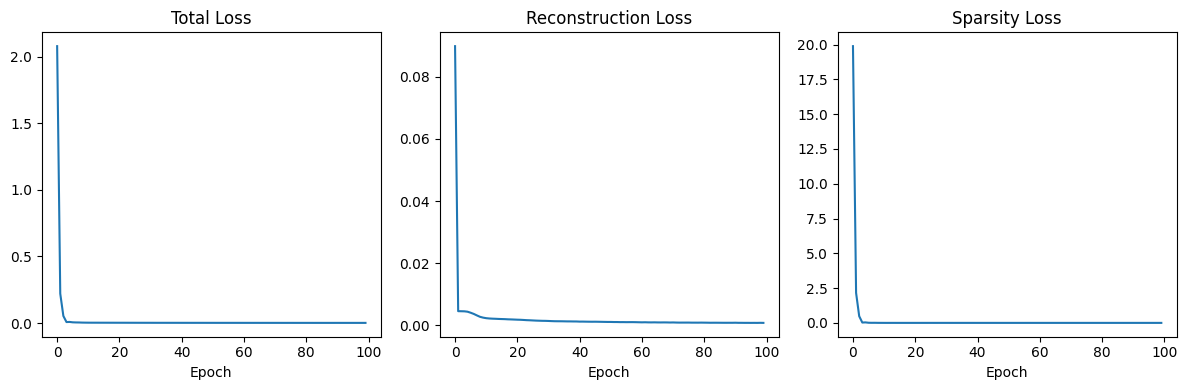

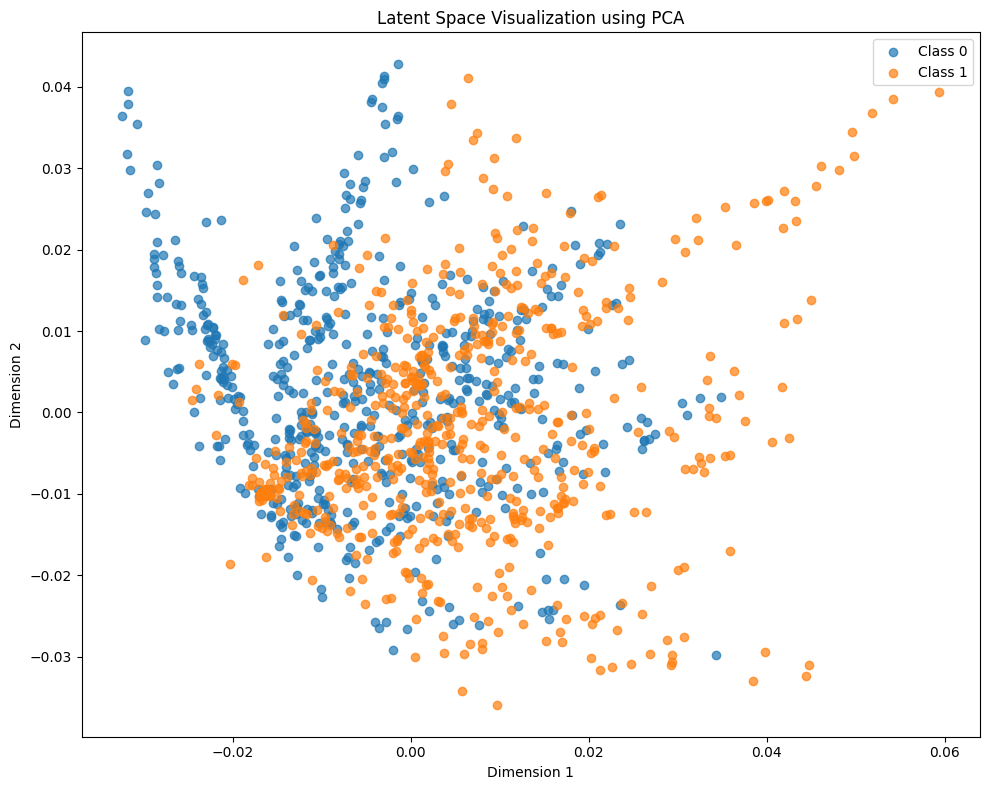

Analyzing sparsity pattern...


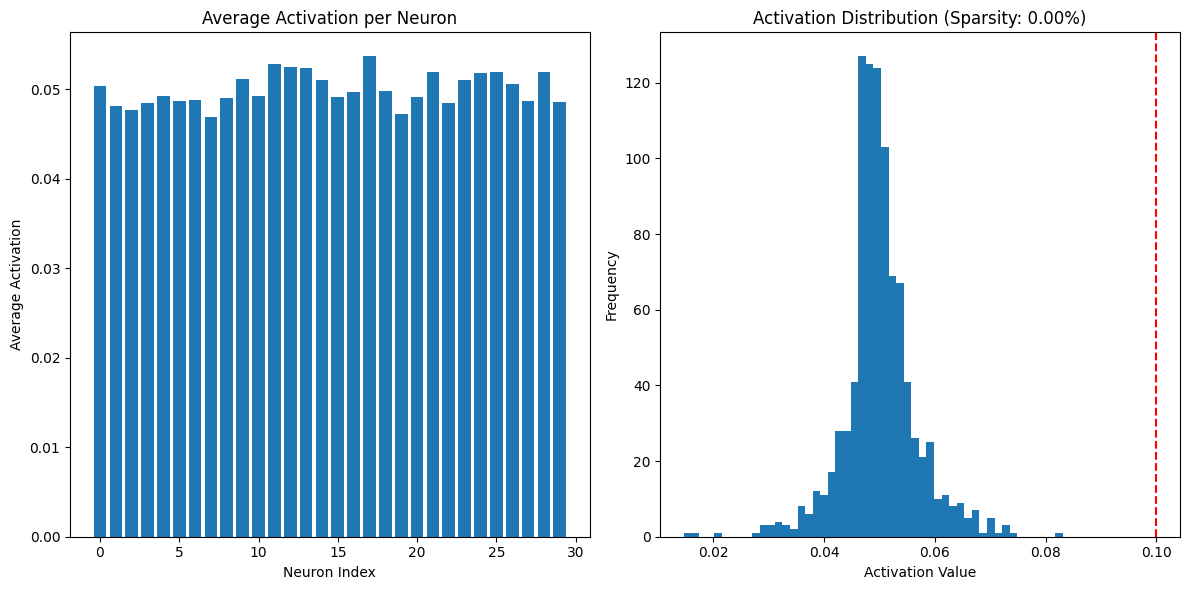

Model sparsity: 0.00% neurons are active
Visualizing reconstructions...


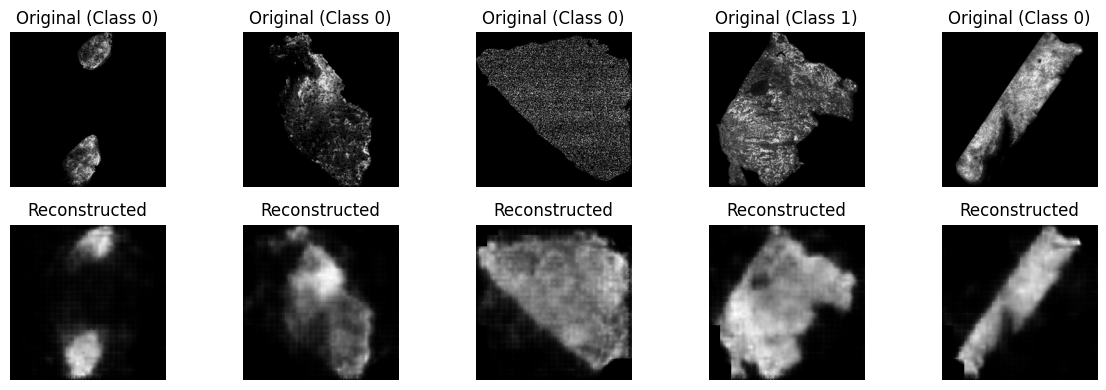

Done!


In [47]:
# Hyperparameters
num_epochs = 100
learning_rate = 1e-3
sparsity_param = 0.05
sparsity_weight = 0.1
latent_size = 30

# Initialize model
model = SparseAutoencoder(latent_size=latent_size, sparsity_param=sparsity_param)

# Train the model
print("Training the Sparse Autoencoder...")
model = train_autoencoder(
    model, 
    dataloader, 
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    sparsity_weight=sparsity_weight
)

# Save the model
torch.save(model.state_dict(), 'sparse_autoencoder.pth')

# Visualize latent space
print("Visualizing latent space...")
visualize_latent_space(model, dataloader, method='PCA')

# Visualize sparsity
print("Analyzing sparsity pattern...")
sparsity = visualize_sparsity(model, dataloader)
print(f"Model sparsity: {sparsity:.2f}% neurons are active")


# Visualize some reconstructions
print("Visualizing reconstructions...")
visualize_reconstructions(model, dataloader)

print("Done!")

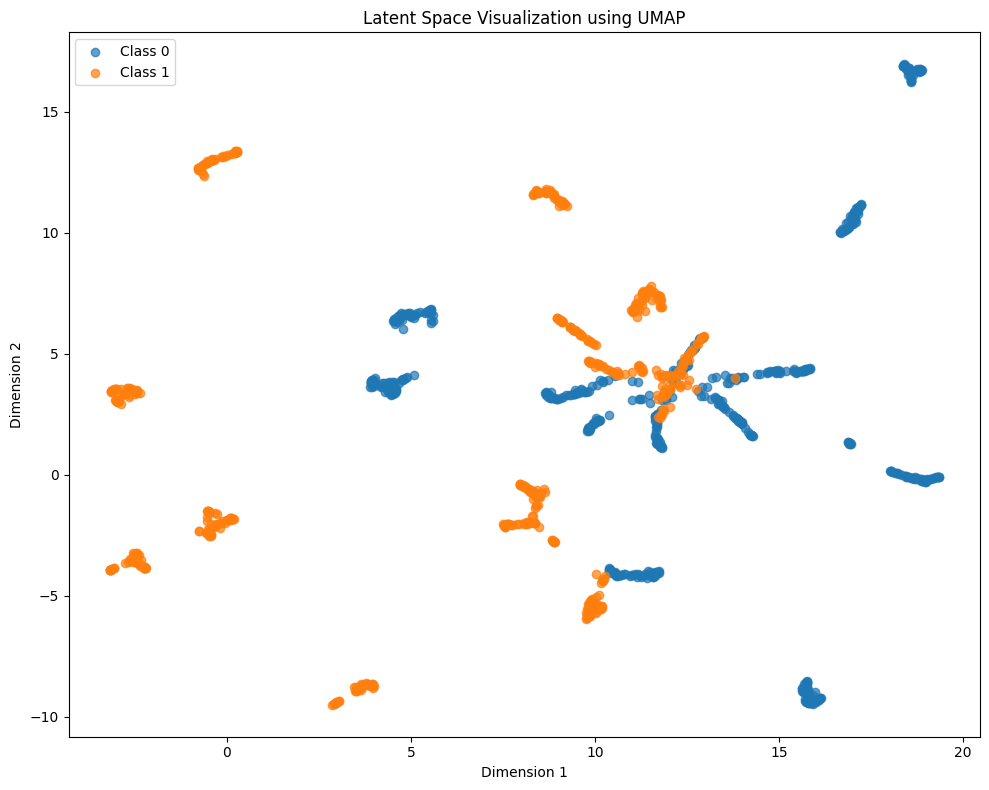

(array([[ 7.67547  , -2.0184107],
        [15.825838 , -9.427025 ],
        [-2.5052443,  3.4779925],
        ...,
        [ 3.7559721, -8.654359 ],
        [ 7.972362 , -0.395894 ],
        [17.172049 , 11.057848 ]], dtype=float32),
 array([1, 0, 1, ..., 1, 1, 0]))

In [48]:
visualize_latent_space(model, dataloader, method='UMAP')

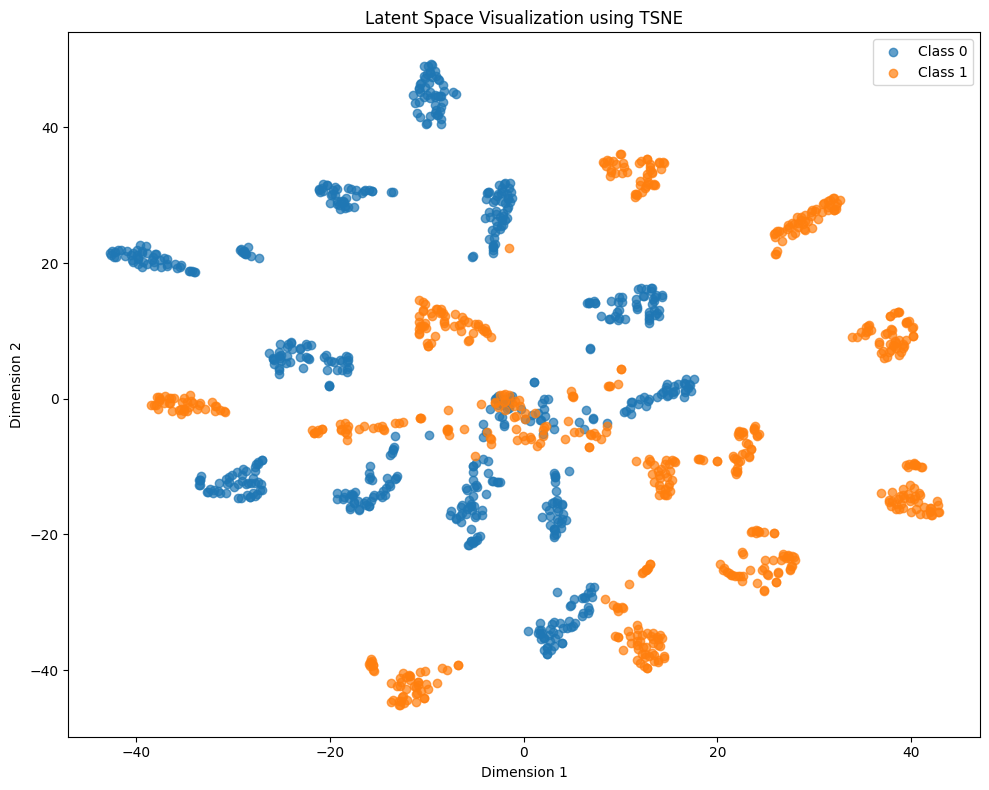

(array([[ -8.539889 ,  41.26599  ],
        [-36.611385 ,  -0.6580553],
        [ 38.71962  ,  12.821239 ],
        ...,
        [ -6.999497 , -17.72872  ],
        [ -2.0454829,  -3.972238 ],
        [  7.231311 ,  14.356828 ]], dtype=float32),
 array([0, 1, 1, ..., 0, 0, 0]))

In [49]:
visualize_latent_space(model, dataloader, method='TSNE')

In [ ]:
class LatentSpaceClassifier(nn.Module):
    def __init__(self, latent_size, num_classes=2):
        super(LatentSpaceClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

# Extract features using the encoder part of the autoencoder
def extract_latent_features(autoencoder, dataloader, device):
    autoencoder.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            encoded, _ = autoencoder(images)
            features.append(encoded.cpu())
            labels.append(targets)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

# Class for the feature dataset
class LatentFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Train the classifier
def train_classifier(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # For early stopping
    best_val_acc = 0
    patience = 5
    counter = 0
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_classifier.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('classifier_training.png')
    plt.show()
    
    # Load the best model
    model.load_state_dict(torch.load('best_classifier.pth'))
    return model

# Evaluate classifier on test set
def evaluate_classifier(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print(classification_report(all_labels, all_preds))
    
    return accuracy, cm

Extracting features: 100%|██████████| 130/130 [00:02<00:00, 62.36it/s]


Training the classifier...
Epoch 1/30, Train Loss: 0.6955, Train Acc: 48.49%, Val Loss: 0.6930, Val Acc: 50.80%
Epoch 2/30, Train Loss: 0.6940, Train Acc: 49.31%, Val Loss: 0.6932, Val Acc: 49.20%
Epoch 3/30, Train Loss: 0.6937, Train Acc: 51.07%, Val Loss: 0.6930, Val Acc: 50.80%
Epoch 4/30, Train Loss: 0.6946, Train Acc: 49.79%, Val Loss: 0.6932, Val Acc: 50.80%
Epoch 5/30, Train Loss: 0.6930, Train Acc: 50.48%, Val Loss: 0.6942, Val Acc: 49.20%
Epoch 6/30, Train Loss: 0.6936, Train Acc: 50.10%, Val Loss: 0.6931, Val Acc: 50.80%
Early stopping at epoch 6


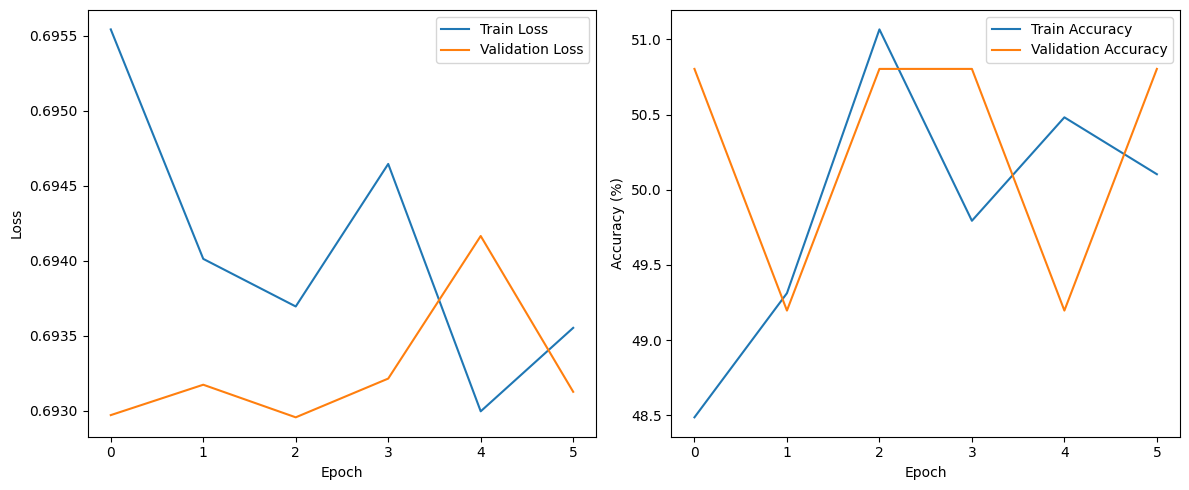

Evaluating the classifier...


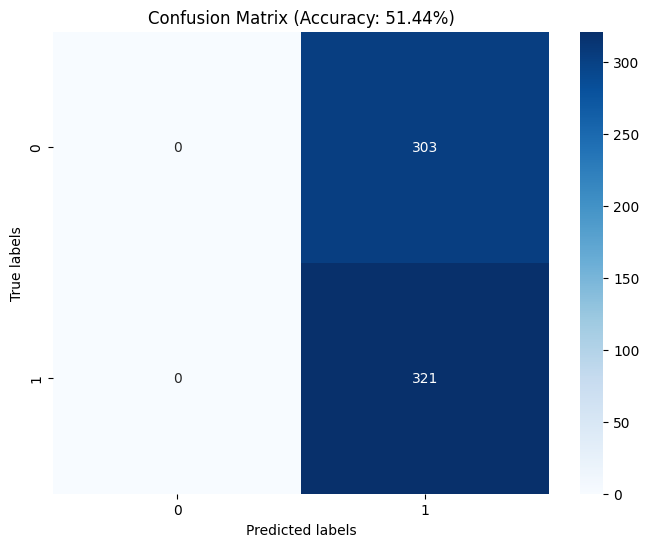

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.51      1.00      0.68       321

    accuracy                           0.51       624
   macro avg       0.26      0.50      0.34       624
weighted avg       0.26      0.51      0.35       624

Final test accuracy: 51.44%


/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [72]:

features, labels = extract_latent_features(model, dataloader, device)

# Create a dataset from the extracted features
feature_dataset = LatentFeatureDataset(features, labels)

# Split into train, validation, and test sets
total_size = len(feature_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    feature_dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create and train the classifier
num_classes = 2  # Binary classification
classifier = LatentSpaceClassifier(latent_size, num_classes)

print("Training the classifier...")
classifier = train_classifier(classifier, train_loader, val_loader)

# Evaluate the classifier
print("Evaluating the classifier...")
accuracy, cm = evaluate_classifier(classifier, test_loader)
print(f"Final test accuracy: {accuracy:.2%}")